## Classification DWEN

In [1]:
import keras
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
# %matplotlib inline
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import keras.backend as K

import os
from keras_bert import load_vocabulary
from keras.layers import concatenate, Dropout, Add
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import _pickle as pickle

Using TensorFlow backend.


## Configurações Globais

In [2]:
# %env epochs=1000
# %env base=eclipse
# %env method=DWEN_QL

env: epochs=1000
env: base=eclipse
env: method=DWEN_QL


In [3]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000
epochs = int(os.environ['epochs'])

In [4]:
DOMAIN = os.environ['base']
METHOD = '{}_{}'.format(os.environ['method'], epochs)
PREPROCESSING = 'bert'
TOKEN = 'bert'
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = '{}_classification({})'.format(METHOD, DOMAIN)
PRETRAINED_MODEL = 'modelos/model_{}_preprocessing_{}_feature_{}epochs_64batch({}).h5'.format(PREPROCESSING, METHOD, str(epochs), DOMAIN)
TEST_PATH = os.path.join(DIR, 'test_classification.txt')

In [5]:
print("*********")
print("{} for {} epochs in {}".format(METHOD, epochs, DOMAIN))
print("*********")

*********
DWEN_QL_1000 for 1000 epochs in eclipse
*********


In [6]:
print(PRETRAINED_MODEL)

modelos/model_bert_preprocessing_DWEN_QL_1000_feature_1000epochs_64batch(eclipse).h5


In [7]:
K.clear_session()

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_layer_title (Embeddin (None, 20, 300)      581600700   title_in[0][0]                   
__________________________________________________________________________________________________
embedding_layer_desc (Embedding (None, 20, 300)      581600700   desc_in[0][0]                    
__________________________________________________________________________________________________
global_ave

In [9]:
MAX_SEQUENCE_LENGTH_T = K.int_shape(similarity_model.input[0])[1]
MAX_SEQUENCE_LENGTH_D = K.int_shape(similarity_model.input[1])[1]

MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D

(20, 20)

In [10]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [11]:
token_dict = load_vocabulary(vocab_path)

In [12]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, 
                    token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [13]:
baseline.info_dict

{'bug_severity': 7,
 'bug_status': 3,
 'component': 927,
 'priority': 5,
 'product': 189,
 'version': 551}

In [14]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

#### Loading bug ids in memory

In [15]:
experiment.load_ids()
print(len(baseline.bug_ids))

Reading bug ids
361006


#### Loading train bugs

In [16]:
%%time

experiment.load_bugs(TOKEN)


CPU times: user 35 s, sys: 3.86 s, total: 38.8 s
Wall time: 37.6 s


In [17]:
%%time
issues_by_buckets = experiment.get_buckets_for_bugs()
experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')


CPU times: user 2.44 s, sys: 12.1 ms, total: 2.45 s
Wall time: 2.42 s


In [18]:
%%time

bug_train_ids = experiment.get_train_ids(baseline.train_data)

CPU times: user 138 ms, sys: 4.11 ms, total: 142 ms
Wall time: 141 ms


In [19]:
print(len(bug_train_ids))

1546362


In [20]:
%%time

baseline.test_data, baseline.dup_sets_test = experiment.read_test_data_classification(DIR, baseline.bug_set, 
                                                                                      bug_train_ids, 
                                                                                      path='test_chronological')

Reading test data for classification
CPU times: user 1.11 s, sys: 3.7 ms, total: 1.11 s
Wall time: 1.11 s


In [21]:
print(len(baseline.test_data))

43399


## Siamese  model

In [22]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [26]:
bug_t_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')
    
title_embed = similarity_model.get_layer('embedding_layer_title')
desc_embed = similarity_model.get_layer('embedding_layer_desc')
title_encoder = similarity_model.get_layer('global_average_pooling1d_1')
desc_encoder = similarity_model.get_layer('global_average_pooling1d_2')

# Bug A
bug_t_a_embed = title_embed(bug_t_a_input)
bug_d_a_embed = desc_embed(bug_d_a_input)
# Bug B
bug_t_b_embed = title_embed(bug_t_b_input)
bug_d_b_embed = desc_embed(bug_d_b_input)

# Bug A
bug_t_a = title_encoder(bug_t_a_embed)
bug_d_a = desc_encoder(bug_d_a_embed)
# Bug B
bug_t_b = title_encoder(bug_t_b_embed)
bug_d_b = desc_encoder(bug_d_b_embed)

if( 'DWEN_QL' in METHOD ):
    model = similarity_model.get_layer('merge_features_in')
else:
    model = similarity_model.get_layer('merge_features_dwen_a')
    
bug_a = model([bug_t_a, bug_d_a])
bug_b = model([bug_t_b, bug_d_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    x = Dense(64)(x)
    x = Dropout(0.25)(x)
    x = Activation('tanh')(x)
    # x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a_input, bug_t_b_input, bug_d_a_input, bug_d_b_input], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_a (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 20)           0                                            
__________________________________________________________________________________________________
title_b (InputLayer)            (None, 20)           0                                            
________________________________________________________________________________________________

In [27]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [28]:
bug_test_ids = experiment.get_train_ids(baseline.test_data)

In [29]:
def batch_classification(train, dup_sets, batch_size, n_neg, bug_ids):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = baseline.batch_iterator(retrieval, None, train, dup_sets, bug_ids, 
                                                                                     batch_size_normalized, n_neg,
                                                                                    issues_by_buckets)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    
    return title_a, title_b, desc_a, desc_b, info_a, info_b, sim

def batch_classification_siamese(train, dup_sets, batch_size, n_neg, bug_ids):
    while True:
        title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(train, dup_sets, batch_size, 
                                                                                     n_neg, bug_ids)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [30]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train,
                                                                             512, 1, bug_train_ids)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [31]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 64, 
                                                             1, bug_train_ids), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 



Epoch 1/1
10/10 [==============================] - 5s 545ms/step - loss: 0.7279 - acc: 0.5087 - val_loss: 0.6909 - val_acc: 0.5020
CPU times: user 6.87 s, sys: 144 ms, total: 7.02 s
Wall time: 5.74 s


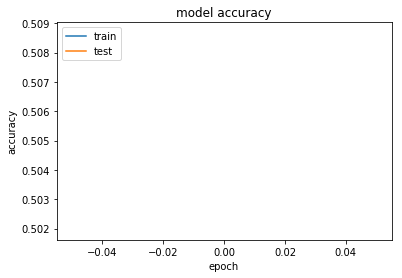

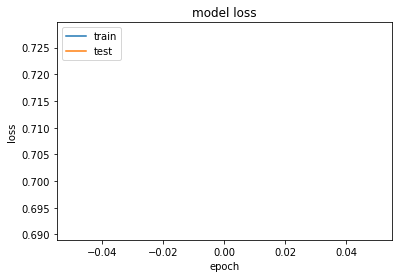

In [32]:
Baseline.validation_accuracy_loss(h_clf)

### Accuracy

In [33]:
result = { }

In [34]:
number_of_pairs = len(baseline.test_data)

#### train

In [35]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, number_of_pairs, 1, 
                                                                             bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_train = accuracy_score(y_true, y_scores)
print("acc_train", acc_train)

acc_train 0.5005760634130605


#### test

In [36]:
number_of_pairs = len(baseline.test_data)

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=False)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_test = accuracy_score(y_true, y_scores)
print("acc_test", acc_test)

acc_test 0.5


### Roc AUC/SCORE

#### train

In [37]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 
                                                                             number_of_pairs, 1, bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_train = roc_auc_score(y_true, y_scores)
print("roc_train", roc_train)

roc_train 0.6056473618888882


#### test

In [38]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=False)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_test = roc_auc_score(y_true, y_scores)
print("roc_test", roc_test)

roc_test 0.5695373601177137


In [39]:
pred = np.argmax(y_scores, axis=1)
pred = pred.tolist()
pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [40]:
label = np.argmax(y_true, axis=1)
label = label.tolist()
label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Normalized confusion matrix
[[0.99440079 0.00559921]
 [0.99440079 0.00559921]]


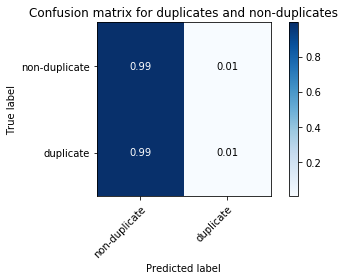

resultados/classification_eclipse_DWEN_QL_1000.png


In [41]:
ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['non-duplicate', 'duplicate']), 
                      title='Confusion matrix for duplicates and non-duplicates', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD), bbox_inches="tight")
print('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD))

Normalized confusion matrix
[[0.99440079 0.00559921]
 [0.99440079 0.00559921]]


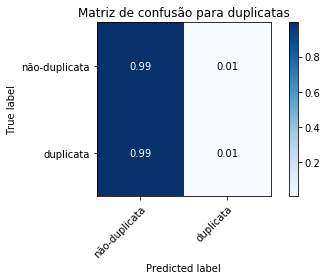

resultados/classification_eclipse_DWEN_QL_1000_pt.png


In [42]:
ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['não-duplicata', 'duplicata']), 
                      title='Matriz de confusão para duplicatas', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD), bbox_inches="tight")
print('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD))

#### Save the model

In [43]:
experiment.save_model(model_clf, SAVE_PATH)

#### Saving the accuracy and roc/auc

In [44]:
CLASSIFICATION_PATH = 'classification_{}.pkl'.format(METHOD)

def save_result(result):
    result = {
        'acc_train' : acc_train,
        'acc_test' : acc_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
        'method' : METHOD
    }

    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'wb') as f:
        pickle.dump(result, f)

print(CLASSIFICATION_PATH)

classification_DWEN_QL_1000.pkl


In [45]:
try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.


In [46]:
try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.


In [47]:
print(result)

{'roc_train': 0.6056473618888882, 'roc_test': 0.5695373601177137, 'acc_test': 0.5, 'acc_train': 0.5005760634130605, 'method': 'DWEN_QL_1000'}
